In [1]:
import astropy.io.fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
import pickle
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd

In [2]:
#Physical constants
c = 3e10
PRES_SI_TO_CGS = 10
k_B = 1.38e-16
h = 6.626e-27
UM_TO_CM = 1e-4
CM_TO_M = 1e-2
uJy_to_CGS = 1e-29
uJy_to_MJy = 1e-12
pc = 3.086e18
AU = 1.5e13
R_jup = 7.1e9
G = 6.67e-8
M_sun = 2e33
sigma_B = 5.67e-5

#System parameters
dist = 630 * pc
P = 0.322963997
T0 = 56130.35411 + 0.25 * P
R_over_D = 1.1 * R_jup / dist

plot_data_dir = "plot_data/"

In [3]:
def flux_to_Tb(wavelengths, fluxes, Rp_over_D):
    Tb = h*c/ wavelengths / k_B / np.log(Rp_over_D**2 * np.pi * 2 * h * c**2 / wavelengths**5 / fluxes + 1)
    return Tb

Figure 1 uses SpiderCat: https://astro.phys.ntnu.no/SpiderCAT/

/tmp/ipykernel_2364510/3384762088.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BWs["a"] = (G * (1.4 * M_sun) / (4 * np.pi**2) * (BWs["PB"] * 3600)**2)**(1/3) / AU
/tmp/ipykernel_2364510/3384762088.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BWs["T"] = (BWs["Edot"] / (16*np.pi*(BWs["a"]*AU)**2 * sigma_B))**(1/4)
/tmp/ipykernel_2364510/3384762088.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

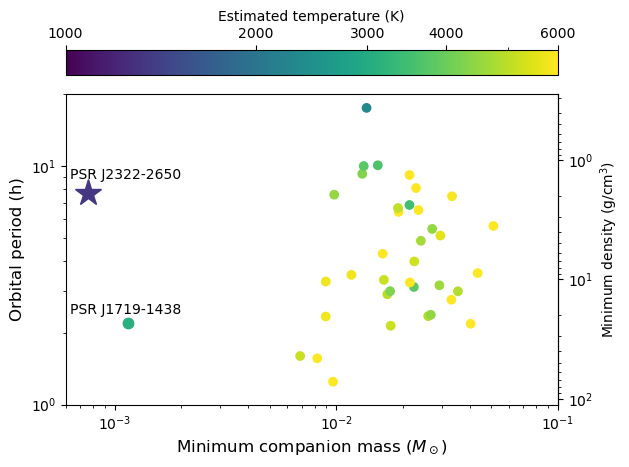

In [4]:
#Figure 1

def Porb_to_rho(Porb_h):
    Porb_s = Porb_h * 3600
    rho_min = 3*np.pi/(0.46**3 * G * Porb_s**2)
    return rho_min

def rho_to_Porb(rho):
    Porb_s = np.sqrt(3*np.pi / (rho * 0.46**3 * G))
    Porb_h = Porb_s / 3600
    return Porb_h
    

df = pd.read_csv("plot_data/spidercat_2025-09-24_00_32_14.csv")
BWs = df[df["Type"] == "BW"]

BWs["a"] = (G * (1.4 * M_sun) / (4 * np.pi**2) * (BWs["PB"] * 3600)**2)**(1/3) / AU
BWs["T"] = (BWs["Edot"] / (16*np.pi*(BWs["a"]*AU)**2 * sigma_B))**(1/4)
BWs["rho_min"] = Porb_to_rho(BWs["PB"])

norm = colors.LogNorm(vmin=1000, vmax=6000)
cmap = cm.viridis

plt.scatter(BWs["MCOMP_i90"], BWs["PB"], c=BWs["T"], cmap=cmap, norm=norm)
cbar = plt.colorbar(orientation="horizontal", location="top", ticks=[1e3, 2e3, 3e3, 4e3, 6e3])
cbar.ax.set_xticklabels(["1000", "2000", "3000", "4000", "6000"])
cbar.set_label("Estimated temperature (K)")
plt.plot(7.588e-4, 7.7, '*', color=cmap(norm(1327)), markersize=20)
plt.text(6.3e-4, 8.8, "PSR J2322-2650")
plt.plot(1.15e-3, 2.2, '.', color=cmap(norm(3128)), markersize=15)
plt.text(0.63e-3, 2.4, "PSR J1719-1438")

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel("Minimum companion mass ($M_\odot$)", fontsize=12)
plt.ylabel("Orbital period (h)", fontsize=12)
plt.xlim(6e-4, 1e-1)
plt.ylim(1, 20)

ax2 = plt.gca().secondary_yaxis("right", functions=(Porb_to_rho, rho_to_Porb))
ax2.set_ylabel("Minimum density (g/cm$^3$)")

plt.tight_layout()
plt.savefig("black_widows.png")

In [5]:
#Read in PRISM data

hdul = astropy.io.fits.open(plot_data_dir + "jw05263001001_nrs1_allspec1d.fits")
phases = (hdul[0].data - T0) / P
phases -= int(np.median(phases))
#print(phases)
data = np.copy(hdul[2].data)
errors = np.copy(hdul[3].data)
mask = np.isnan(hdul[2].data) | (hdul[4].data > 0.2) | (hdul[5].data > 0.3) | (hdul[6].data > 0.8)

col_bad = np.zeros(mask.shape[1], dtype=bool)
for col in range(data.shape[1]):
    if np.all(mask[:,col]):
        col_bad[col] = True

waves = hdul[1].data[~col_bad]
data = data[:,~col_bad]
errors = errors[:,~col_bad]
mask = mask[:,~col_bad]

In [6]:
#Load G235H data

data1 = astropy.io.fits.open(plot_data_dir + "jw05263001001_nrs1_grism.fits")
data2 = astropy.io.fits.open(plot_data_dir + "jw05263001001_nrs2_grism.fits")

start = 115

combined_waves = np.append(data1[1].data, data2[1].data)
combined_data = uJy_to_MJy * np.hstack([data1[2].data, data2[2].data])
combined_data[np.isnan(combined_data)] = 0

combined_errors = uJy_to_MJy * np.hstack([data1[3].data, data2[3].data])

combined_lost = np.hstack([data1[4].data, data2[4].data])
combined_adj_lost = np.hstack([data1[5].data, data2[5].data])
combined_diag_lost = np.hstack([data1[6].data, data2[6].data])
combined_mask = (combined_lost > 0.2) | (combined_adj_lost > 0.3) | (combined_diag_lost > 0.4)
combined_data[combined_mask] = 0

combined_data = combined_data[:,start:]
combined_waves = combined_waves[start:]
combined_mask = combined_mask[:,start:]
combined_errors = combined_errors[:,start:]

#Interpolate over outliers
for r in range(combined_data.shape[0]):
    cols = np.arange(combined_data.shape[1])
    good = ~combined_mask[r]
    combined_data[r] = np.interp(cols, cols[good], combined_data[r][good])

#Reject wavelengths where more than 50% of timestamps are masked
bad_col = np.sum(combined_mask, axis=0) > combined_mask.shape[0] / 2
combined_waves = combined_waves[~bad_col]
combined_data = combined_data[:,~bad_col]
combined_errors = combined_errors[:,~bad_col]

times = data1[0].data
g235h_phases = (times - T0) / P
g235h_phases -= int(np.median(g235h_phases))

red_cutoff = 3.041 #beyond this cutoff, the G235H throughput dramatically drops
dayside = np.abs(g235h_phases - 0.5) < 0.085
g235h_spec = np.mean(combined_data[dayside], axis=0)[combined_waves < red_cutoff] / uJy_to_MJy
g235h_waves = combined_waves[combined_waves < red_cutoff]
g235h_err = np.median(combined_errors[dayside], axis=0)[combined_waves < red_cutoff] / np.sqrt(np.sum(dayside)) / uJy_to_MJy

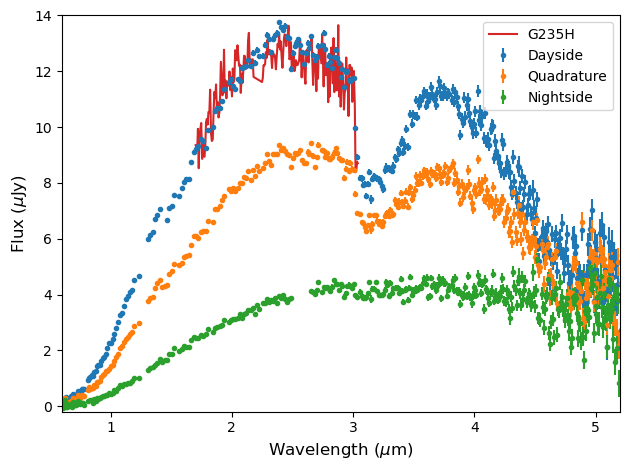

In [7]:
dayside = np.abs(phases - 0.5) < 0.085
dayside_spec = np.median(data[dayside], axis=0)
dayside_spec_err = np.median(errors[dayside], axis=0) / np.sqrt(np.sum(dayside)) #* 1.25
plt.errorbar(waves, dayside_spec, yerr=dayside_spec_err, fmt='.', label="Dayside")

quad = (np.abs(phases - 0.25) < 0.05) | (np.abs(phases - 0.75) < 0.05)
quad_spec = np.mean(data[quad], axis=0)
quad_spec_err = np.median(errors[quad], axis=0) / np.sqrt(np.sum(quad))
plt.errorbar(waves, quad_spec, yerr=quad_spec_err, fmt='.', label="Quadrature")

nightside = (np.abs(phases - 0.) < 0.05) | (np.abs(phases - 1.0) < 0.05)
nightside_spec = np.mean(data[nightside], axis=0)
nightside_spec_err = np.median(errors[nightside], axis=0) / np.sqrt(np.sum(nightside))
plt.errorbar(waves, nightside_spec, yerr=nightside_spec_err, fmt='.', label="Nightside")

b = 16
plt.plot(g235h_waves[::b], uniform_filter(g235h_spec, b)[::b], label="G235H")

plt.xlim(0.6, 5.2)
plt.ylim(-0.2, 14)

plt.xlabel("Wavelength ($\mu$m)", fontsize=12)
plt.ylabel("Flux ($\mu$Jy)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig("spectra_different_phases.png")

In [8]:
#Write the spectra we just plotted to text files

f = open("g235h_spec.txt", "w")
f.write("Wavelength(um) Flux(uJy) Error(uJy)\n")
for i in range(len(g235h_waves)):
    f.write("{} {}\n".format(g235h_waves[i], g235h_spec[i], g235h_err[i]))
f.close()

f = open("prism_dayside_spec.txt", "w")
f.write("Wavelength(um) Flux(uJy) Error(uJy)\n")
for i in range(len(waves)):
    f.write("{} {} {}\n".format(waves[i], dayside_spec[i], dayside_spec_err[i]))
f.close()

f = open("prism_quad_spec.txt", "w")
f.write("Wavelength(um) Flux(uJy) Error(uJy)\n")
for i in range(len(waves)):
    f.write("{} {}\n".format(waves[i], quad_spec[i], quad_spec_err[i]))
f.close()

f = open("prism_nightside_spec.txt", "w")
f.write("Wavelength(um) Flux(uJy) Error(uJy)\n")
for i in range(len(waves)):
    f.write("{} {}\n".format(waves[i], nightside_spec[i], nightside_spec_err[i]))
f.close()

/tmp/ipykernel_2364510/871900023.py:2: RuntimeWarning: invalid value encountered in log
  Tb = h*c/ wavelengths / k_B / np.log(Rp_over_D**2 * np.pi * 2 * h * c**2 / wavelengths**5 / fluxes + 1)


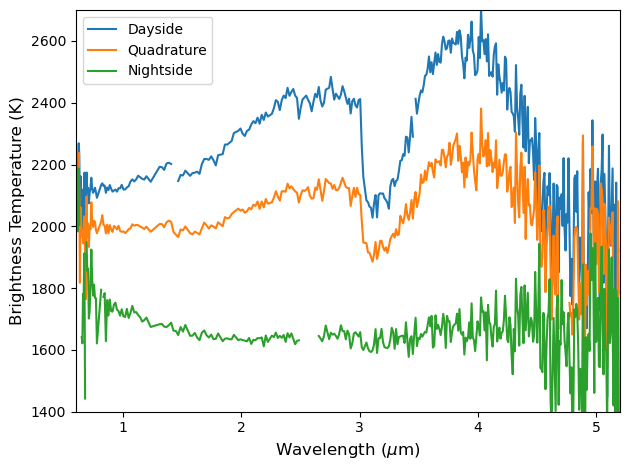

In [9]:
#Convert fluxes to brightness temperatures

factor = c/ (waves * UM_TO_CM)**2 * uJy_to_CGS * (dist / AU)**2
F_lam = factor * data #c/ (waves * UM_TO_CM)**2 * (data * uJy_to_CGS) * (dist / AU)**2

conds = [np.abs(phases - 0.5) < 0.085,
         (np.abs(phases - 0.25) < 0.05) | (np.abs(phases - 0.75) < 0.05),
         (np.abs(phases - 0.) < 0.05) | (np.abs(phases - 1.0) < 0.05)]
all_Tbs = []

labels = ["Dayside", "Quadrature", "Nightside"]

for i in range(len(labels)):    
    #Uncomment the commented code below to calculate and plot error bars
    
    spec = np.mean(F_lam[conds[i]], axis=0) * (dist / AU)**-2
    #spec_err = np.median(F_lam_err[conds[i]], axis=0) * (dist / AU)**-2 / np.sqrt(np.sum(conds[i]))
    
    Tb = flux_to_Tb(waves * UM_TO_CM, spec, R_over_D)
    all_Tbs.append(Tb)
    #Tb_upper_err = flux_to_Tb(waves * UM_TO_CM, spec + spec_err, R_over_D) - Tb
    #Tb_lower_err = Tb - flux_to_Tb(waves * UM_TO_CM, spec - spec_err, R_over_D)
    plt.plot(waves, Tb, label=labels[i]) #, yerr=(Tb_lower_err, Tb_upper_err), fmt='.')

plt.xlabel("Wavelength ($\mu$m)", fontsize=12)
plt.ylabel("Brightness Temperature (K)", fontsize=12)


plt.xlim(0.6, 5.2)
plt.ylim(1400, 2700)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("Tb_different_phases.png")

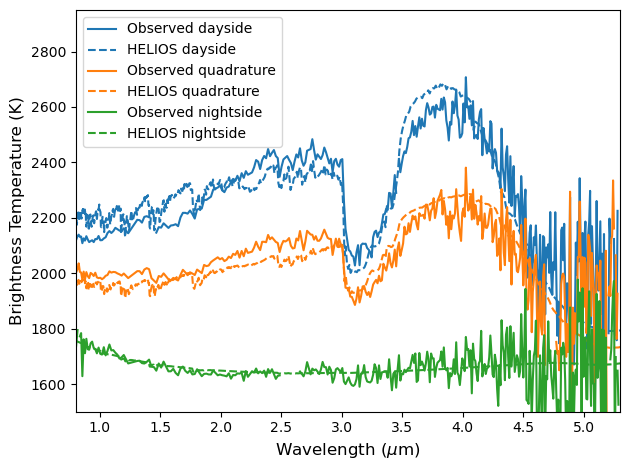

In [10]:
#Figure 2 (right)

filenames = [plot_data_dir + "pulsar_planet_day_TOA_flux_eclipse.dat",
             plot_data_dir + "pulsar_planet_quad_TOA_flux_eclipse.dat",
             plot_data_dir + "pulsar_planet_night_TOA_flux_eclipse.dat"]
colors = ['C0', 'C1', 'C2']
labels = ["dayside", "quadrature", "nightside"]

for i in range(len(filenames)):
    helios_waves, helios_fluxes = np.loadtxt(filenames[i],
                                 usecols=(1,5), unpack=True, skiprows=3)
    helios_Tb = h*c/(helios_waves*UM_TO_CM*k_B) / np.log(np.pi*2*h*c**2/(helios_waves*UM_TO_CM)**5 / helios_fluxes + 1)

    plt.plot(waves, all_Tbs[i], label=f"Observed {labels[i]}", color=colors[i])
    plt.plot(helios_waves, helios_Tb, label=f"HELIOS {labels[i]}", linestyle='--', color=colors[i])

plt.xlabel("Wavelength ($\mu$m)", fontsize=12)
plt.ylabel("Brightness Temperature (K)", fontsize=12)
plt.xlim(0.8, 5.3)
plt.ylim(1500, 2950)
plt.legend()
plt.tight_layout()
plt.savefig("helios_vs_data.png")

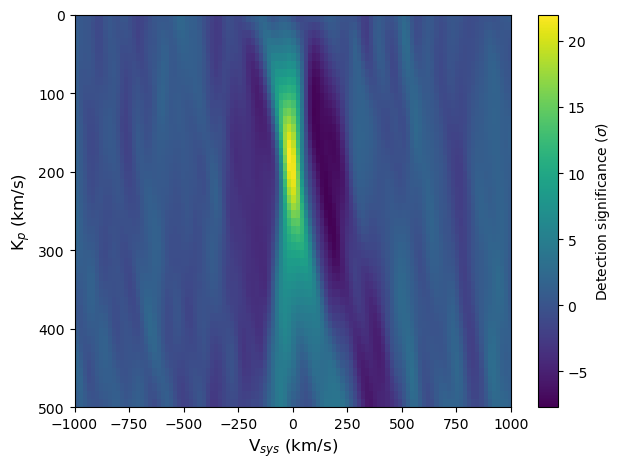

In [11]:
#Figure 3 (left)

f = pickle.load(open(plot_data_dir + "blob_plot.pkl", "rb"))
heatmap = f["heatmap"]
Vsys = f["Vsys"]
Kps = f["Kps"]

plt.imshow(heatmap, extent=(Vsys[0], Vsys[-1], Kps[-1], Kps[0]), aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Detection significance ($\sigma$)")
plt.xlim(-1000, 1000)
plt.xlabel("V$_{sys}$ (km/s)", fontsize=12)
plt.ylabel("K$_p$ (km/s)", fontsize=12)
plt.tight_layout()

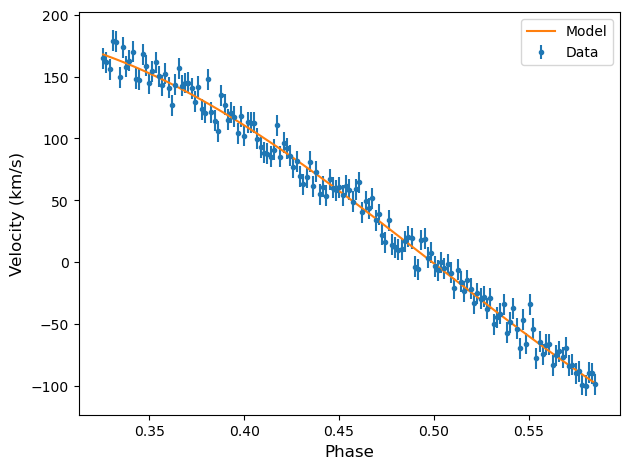

In [12]:
#Figure 3 (right)

f = pickle.load(open(plot_data_dir + "vel_fit.pkl", "rb"))
result = f["dynesty_result"]
Kp, offset, error = result.samples[np.argmax(result.logl)]
model_vels = Kp * np.sin(2*np.pi*f["phases"]) + offset

plt.errorbar(f["phases"], f["velocities"], yerr=error, fmt='.', label="Data")
plt.plot(f["phases"], model_vels, label="Model")
plt.xlabel("Phase", fontsize=12)
plt.ylabel("Velocity (km/s)", fontsize=12)
plt.legend()
plt.tight_layout()

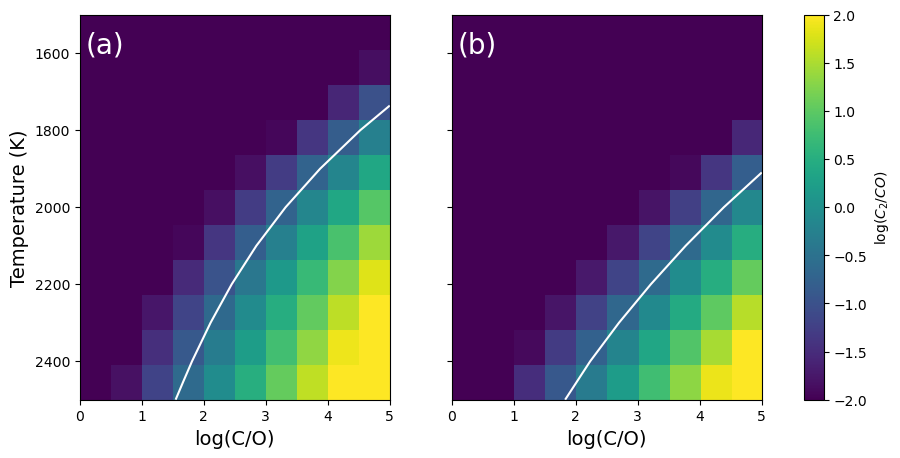

In [13]:
#Figure 4

def plot_eqchem(filename, ax):
    f = pickle.load(open(filename, "rb"))
    Ts = f["Ts"]
    CO_ratios = f["CO_ratios"]
    C2_to_CO = f["C2_to_CO"]
    X, Y  = np.meshgrid(np.log10(CO_ratios), Ts)
    im = ax.imshow(np.log10(C2_to_CO), vmin=-2, vmax=2, extent=(np.log10(CO_ratios[0]), np.log10(CO_ratios[-1]), Ts[-1], Ts[0]), aspect='auto')
    ax.contour(X, Y, np.log10(C2_to_CO), levels=[-0.74], colors='white', linewidths=1.5, linestyles=['-'])
    return im

fig, axes = plt.subplots(1,2, sharey=True, figsize=(11,5))
axes[0].text(0.1, 1600, "(a)", color="w", fontsize=20)
im = plot_eqchem("plot_data/eq_chem_grid_onlyC.pkl", axes[0])
im = plot_eqchem("plot_data/eq_chem_grid_manyelements.pkl", axes[1])
axes[0].set_xlabel("log(C/O)", fontsize=14)
axes[0].set_ylabel("Temperature (K)", fontsize=14)
axes[1].set_xlabel("log(C/O)", fontsize=14)
axes[1].text(0.1, 1600, "(b)", color="w", fontsize=20)
fig.colorbar(im, ax=axes.ravel().tolist(), label=r"$\log(C_2/CO)$")
plt.savefig("C2_CO_ratios.pdf")

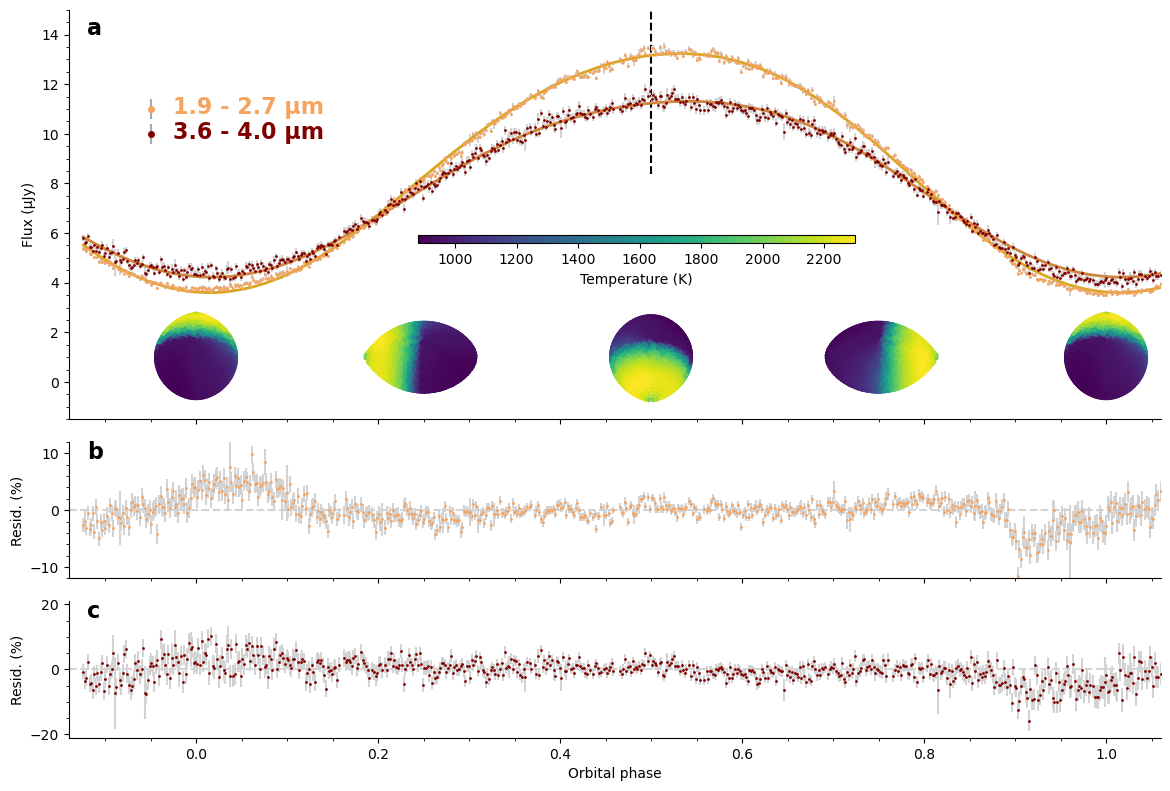

In [14]:
#Figure 5

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

z_05,y_05,T_05 = np.loadtxt('plot_data/f_0.50_zyT.txt', unpack=True)
z_075,y_075,T_075 = np.loadtxt('plot_data/f_0.75_zyT.txt', unpack=True)
z_10,y_10,T_10 = np.loadtxt('plot_data/f_1.00_zyT.txt', unpack=True)
z_125,y_125,T_125 = np.loadtxt('plot_data/f_1.25_zyT.txt', unpack=True)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(12,8),
                                  gridspec_kw = {'height_ratios':[6,2,2], 'hspace':0.1})

txt_phases, blue_lc, blue_lc_err = np.loadtxt("plot_data/band1.9_microJy.txt", unpack=True)
txt_phases -= 0.25
_, red_lc, red_lc_err = np.loadtxt("plot_data/band3.6_microJy.txt", unpack=True)
_, model_blue = np.loadtxt("plot_data/band1.9_model_microJy.txt", unpack=True)
_, model_red = np.loadtxt("plot_data/band3.6_model_microJy.txt", unpack=True)

#### PANEL A ####

ax1.errorbar(txt_phases, blue_lc, yerr=blue_lc_err, 
             fmt='.', ms=2, color='sandybrown', ecolor='lightgray', zorder=2)
ax1.errorbar(txt_phases, red_lc, yerr=red_lc_err, 
             fmt='.', ms=2, color='maroon', ecolor='lightgray', zorder=2)
ax1.plot(txt_phases, model_blue,
        lw=2, color='goldenrod')
ax1.plot(txt_phases, model_red,
        lw=2, color='peru')

ax1.axvline(x=0.5, ymin=0.6, ymax=1., color='k', ls='--', zorder=1)

ax1.errorbar([-0.05], [11], yerr=0.4, color='sandybrown', ecolor='darkgrey', fmt='o', ms=4)
ax1.annotate('1.9 - 2.7 µm', xy=(-0.05+0.025, 11-0.2), 
             fontsize=16, fontweight='bold', color='sandybrown')

ax1.errorbar([-0.05], [10], yerr=0.4, color='maroon', ecolor='darkgrey', fmt='o', ms=4)
ax1.annotate('3.6 - 4.0 µm', xy=(-0.05+0.025, 10-0.2), 
             fontsize=16, fontweight='bold', color='maroon')

# Visualizations
im1 = ax1.scatter(y_075+0.5, 32*z_075+1, c=T_075, s=3, 
                 vmin=880, vmax=2300)
im1 = ax1.scatter(y_05+0.25, 32*z_05+1, c=T_05, s=3, 
                 vmin=880, vmax=2300)
im1 = ax1.scatter(y_125+0., 32*z_125+1, c=T_125, s=3, 
                 vmin=880, vmax=2300)
im1 = ax1.scatter(y_125+1., 32*z_125+1, c=T_125, s=3, 
                 vmin=880, vmax=2300)
im1 = ax1.scatter(y_10+0.75, 32*z_10+1, c=T_10, s=3, 
                 vmin=880, vmax=2300)

fig.canvas.draw()
cax = ax1.inset_axes([0.32, 0.43, 0.4, 0.02])
cbar = fig.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label("Temperature (K)")


ax1.minorticks_on()
ax1.set_ylim(-1.5,15)
ax1.set_ylabel("Flux (µJy)")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_rasterized(True)


#### PANEL B ####

ax2.errorbar(txt_phases, 100*(blue_lc - model_blue) / blue_lc, yerr=100*blue_lc_err / blue_lc, 
            fmt='.', ms=2, color='sandybrown', ecolor='lightgray', zorder=2)
ax2.axhline(0, xmin=0, xmax=1, color='lightgray', ls='--', zorder=1)

ax2.minorticks_on()
ax2.set_ylim(-12,12)
ax2.set_ylabel("Resid. (%)")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#### PANEL C ####

ax3.errorbar(txt_phases, 100*(red_lc - model_red) / red_lc, yerr=100*red_lc_err / red_lc, 
            fmt='.', ms=2, color='maroon', ecolor='lightgray', zorder=2)
ax3.axhline(0, xmin=0, xmax=1, color='lightgray', ls='--', zorder=1)

ax3.minorticks_on()
ax3.set_xlim(-0.14,1.06)
ax3.set_ylim(-21,21)
ax3.set_ylabel("Resid. (%)")
ax3.set_xlabel("Orbital phase")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


ax1.annotate('a', xy=(-0.12, 14), fontsize=16, fontweight='bold')
ax2.annotate('b', xy=(-0.12, 9), fontsize=16, fontweight='bold')
ax3.annotate('c', xy=(-0.12, 16), fontsize=16, fontweight='bold')

plt.subplots_adjust(left=0.08, right=0.99, top=0.99, bottom=0.08, hspace=0.1)

The plot above shows the same light curves plotted in the paper.  We did not include the code that generates the light curves from the FITS files, because it involves quite a bit of processing.  However, here is a simplified code that generates a very close approximation of the observational results above (within 2%):

Text(0.5, 0, 'Orbital Phase')

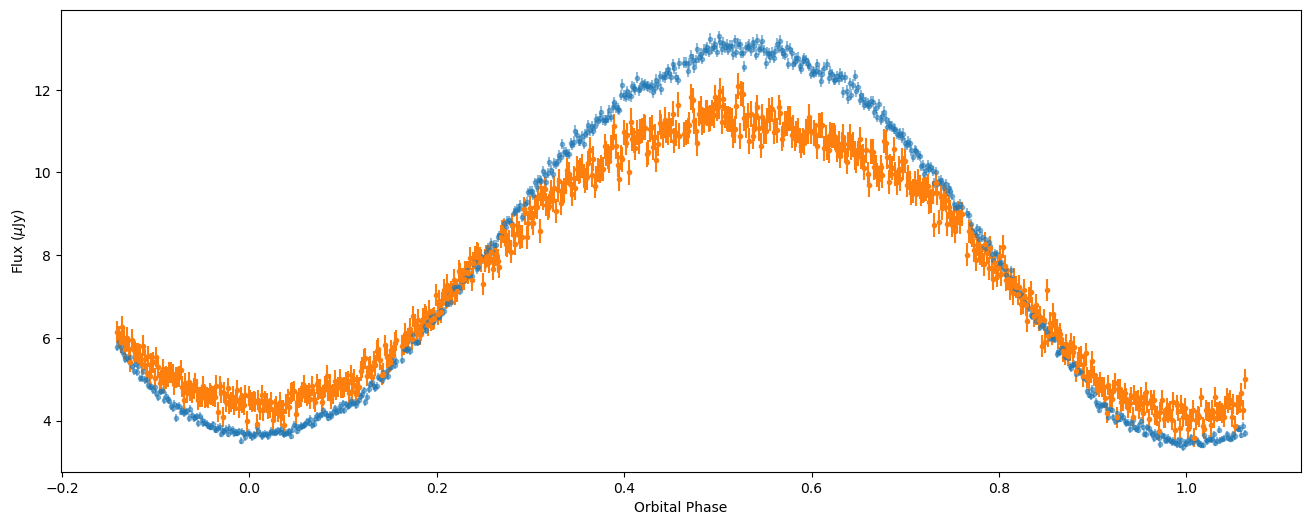

In [15]:
nu = c / (UM_TO_CM * waves)
dnu = -np.gradient(nu)

blue = (waves > 1.9) & (waves < 2.7)
red = (waves > 3.6) & (waves < 4.0)
blue_lc = (data * dnu)[:,blue].sum(axis=1) / (np.max(nu[blue]) - np.min(nu[blue]))
blue_lc_err = np.sqrt((errors**2 * dnu**2)[:,blue].sum(axis=1) / (np.max(nu[blue]) - np.min(nu[blue]))**2)
red_lc = (data * dnu)[:,red].sum(axis=1) / (np.max(nu[red]) - np.min(nu[red]))
red_lc_err = np.sqrt((errors**2 * dnu**2)[:,red].sum(axis=1) / (np.max(nu[red]) - np.min(nu[red]))**2)

plt.figure(figsize=(16,6))
plt.errorbar(phases, blue_lc, yerr=blue_lc_err, fmt='.', alpha=0.5)
plt.errorbar(phases, red_lc, yerr=red_lc_err, fmt='.')

plt.ylabel("Flux ($\mu$Jy)")
plt.xlabel("Orbital Phase")